In [1]:
import os
import sys
import numpy as np
import pandas as pd
import torch
from torch import nn
import cv2
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid , save_image

# Path initialization
sys.path.insert(0, "../condvae_celeba/models/")
from VAE import VAE1
from CondVAE import CondVAE

from dataset import (ATTR_TO_IX_DICT, ATTR_IX_TO_KEEP, IX_TO_ATTR_DICT, N_ATTRS, 
                     FaceData_with_Attributes, tensor_to_attributes)

%matplotlib inline

In [2]:
def show(file_name, name, img, dpi=300, fontsize=10):
    npimg = img.numpy().transpose(1, 2, 0) 
    plt.figure(dpi=dpi)
    plt.title(file_name, fontsize=fontsize)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(npimg)
    plt.savefig(name)
    plt.show()

### Conditional VAE

In [3]:
model = CondVAE(hid_dim=128, KOF=32, p=0.04, N_ATTRS=N_ATTRS)
model.load_state_dict(torch.load("../condvae_celeba/weights/CondVAE_Liza_24_10_2019_02_04/weight.epoch_3_itr_94_loss_val_0.27323706766576256.pth"))
model = model.cuda()
model.eval()

CondVAE(
  (VAE): VAE1(
    (encoder): Sequential(
      (block01): Conv_block(
        (conv): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04, inplace=False)
        (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block02): Conv_block(
        (conv): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04, inplace=False)
        (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (block03): Conv_block(
        (conv): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
        (dropout): Dropout2d(p=0.04, inplace=False)
        (batch_norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

In [4]:
df_attr_path = "../condvae_celeba/data/dataframes/df_attr.csv"
df_attr = pd.read_csv(df_attr_path)
img_path = "../../img_align_celeba"

img_names = {"train": df_attr.img_name.values[:55000], "val": df_attr.img_name.values[55000:]}
datasets = {phase: FaceData_with_Attributes(img_names[phase], img_path, df_attr_path) 
                for phase in ["train", "val"]}

dataloaders = {phase: DataLoader(datasets[phase], batch_size=128, shuffle=True, num_workers=2) 
               for phase in ["train", "val"]}

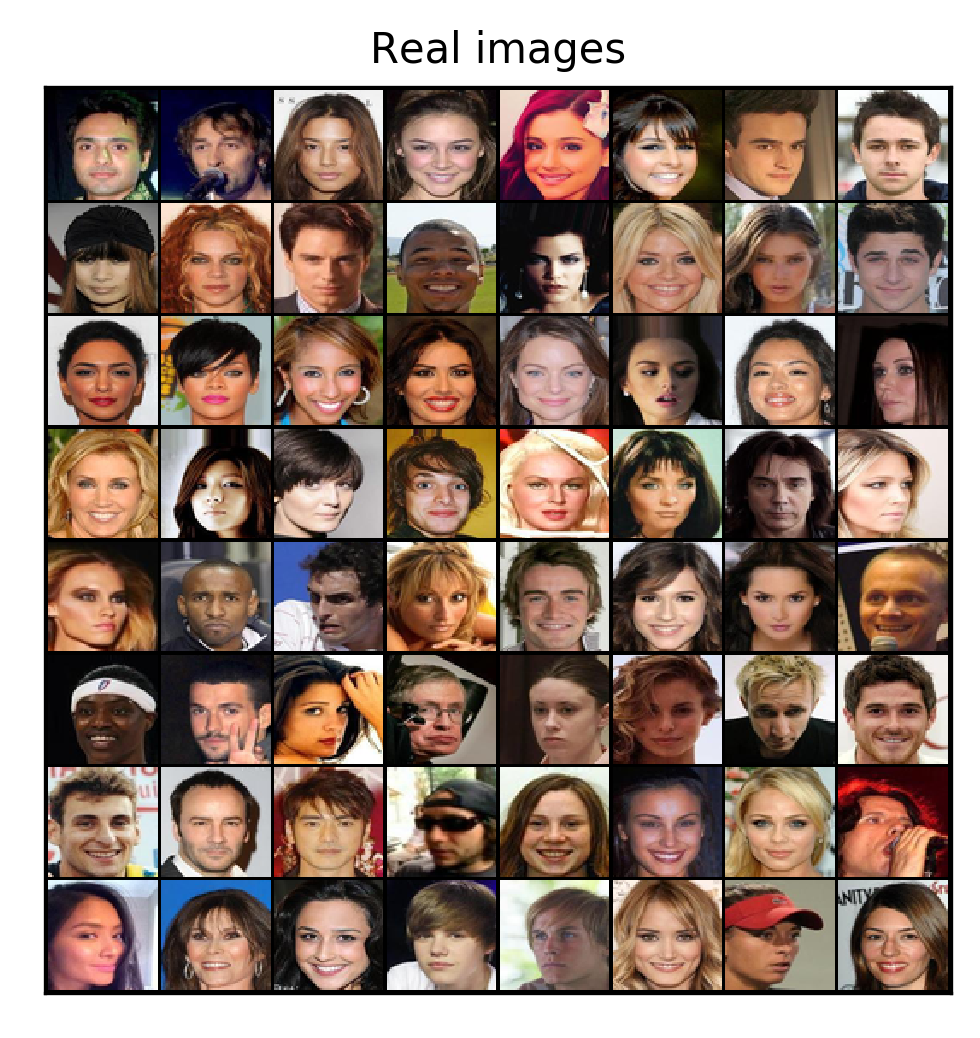

In [5]:
data, attr = next(iter(dataloaders["train"]))

show("Real images", 'ds', make_grid((data[:64]).cpu(), 8))

In [6]:
def generate_images_with_attrs(model, with_attr_list=[], no_attr_list=[], N=64, device=torch.device("cpu")):
    recon_images = []
    image_attrs = []
    
    for i in range(N):
        attrs = torch.zeros(40)

        inds = np.arange(40)
        np.random.shuffle(inds)
        attrs[list(inds)[:10]] = 1
        
        for attr_name in with_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 1
            
        for attr_name in no_attr_list:
            ind = ATTR_TO_IX_DICT[attr_name]
            attrs[ind] = 0

        attrs = attrs[ATTR_IX_TO_KEEP].cuda()
        image_attrs.append(attrs)

        recon_image, recon_attrs, mu, logvar = model(attrs=attrs[None], device=device)
        recon_image = torch.sigmoid(recon_image)
        recon_images.append(recon_image[0])
    
    recon_images = torch.stack(recon_images, dim=0)
    recon_images = recon_images.detach()
    
    image_attrs = torch.stack(image_attrs, dim=0)
    return recon_images, image_attrs

## Attr classifier

In [7]:
import torchvision
clf = torchvision.models.resnet34(pretrained=True)
clf.fc = nn.Linear(512, N_ATTRS) 

clf.load_state_dict(torch.load("../attr_classifier/resnet34_weights.py"))
device=torch.device("cuda:0")
clf = clf.to(device)
clf.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
attr_of_interest_to_idx = {
    'Heavy_Makeup':8, 
    'Wearing_Hat':17, 
    'Male': 9, 
    'Smiling': 14, 
    'Eyeglasses': 6}

In [9]:
def gen_accuracy(model, clf, with_attr_list=[], no_attr_list=[], N=64, device=torch.device("cpu")):
    
    attr_to_accuracy = { key: [] for key in with_attr_list}

    recon_images, image_attrs = generate_images_with_attrs(model, with_attr_list, no_attr_list, N, device)

    for i in tqdm(range(0, N, 100)):
        imgs = recon_images[i: i+100, :, :, :]
        attr = image_attrs[i: i+100, :]

        output = clf(imgs.to(device))
        output = torch.sigmoid(output).cpu()

        prediction = torch.zeros_like(output)
        prediction[output > 0.5] = 1

        running_rights_all = (attr.cpu() == prediction.cpu())


        for attr_name in with_attr_list:
            ind = attr_of_interest_to_idx[attr_name]
            attr_to_accuracy[attr_name].append(running_rights_all[:, ind].sum().float() / 100)


    for attr_name in attr_to_accuracy.keys():
        print("Accuraci for attr '{}': {}".format(attr_name, np.mean(attr_to_accuracy[attr_name])))



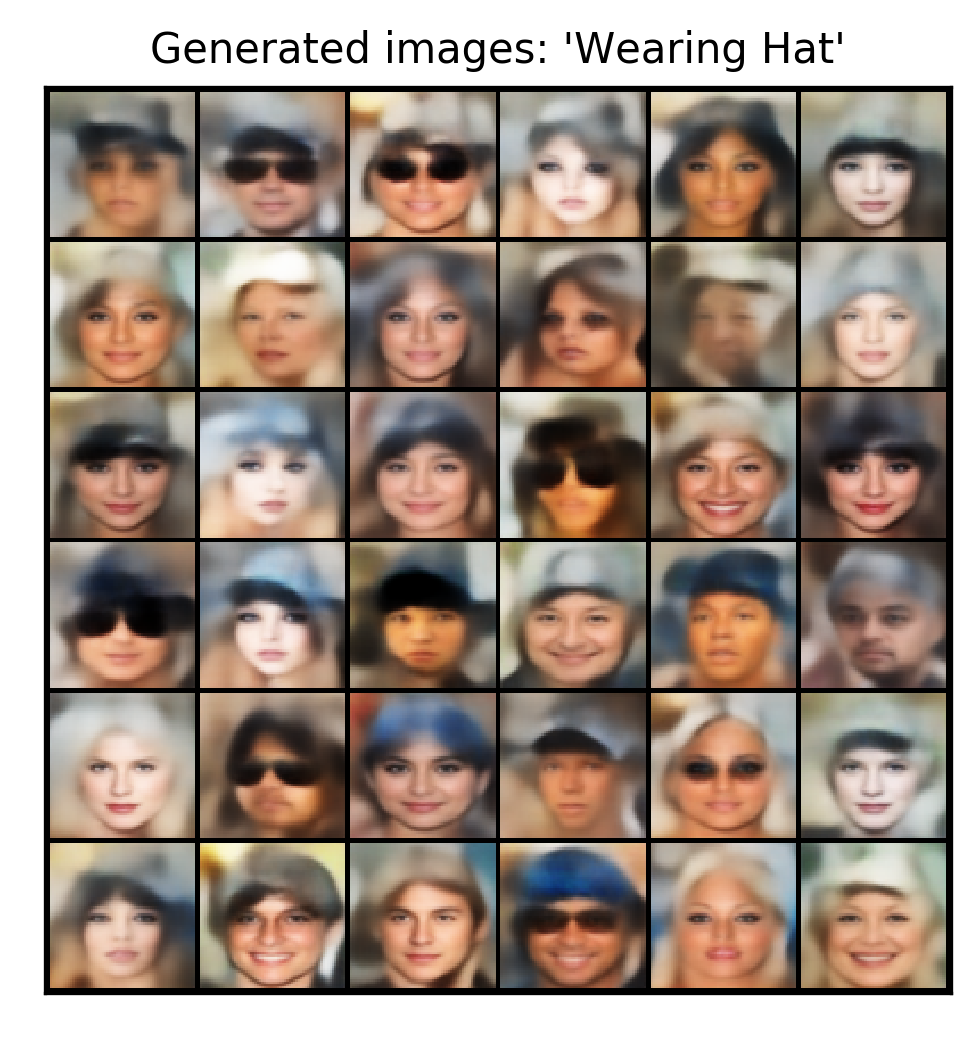

In [22]:
recon_images, _ = generate_images_with_attrs(model, ["Wearing_Hat"], N=36, device=torch.device("cuda:0"))
show("Generated images: 'Wearing Hat'", "model_good_Wearing_Hat.png", make_grid((recon_images).cpu(), 6))

In [ ]:
gen_accuracy(model, clf, ["Wearing_Hat"], N=1000, device=torch.device("cuda:0"))

#### Generate: "Eyeglasses"

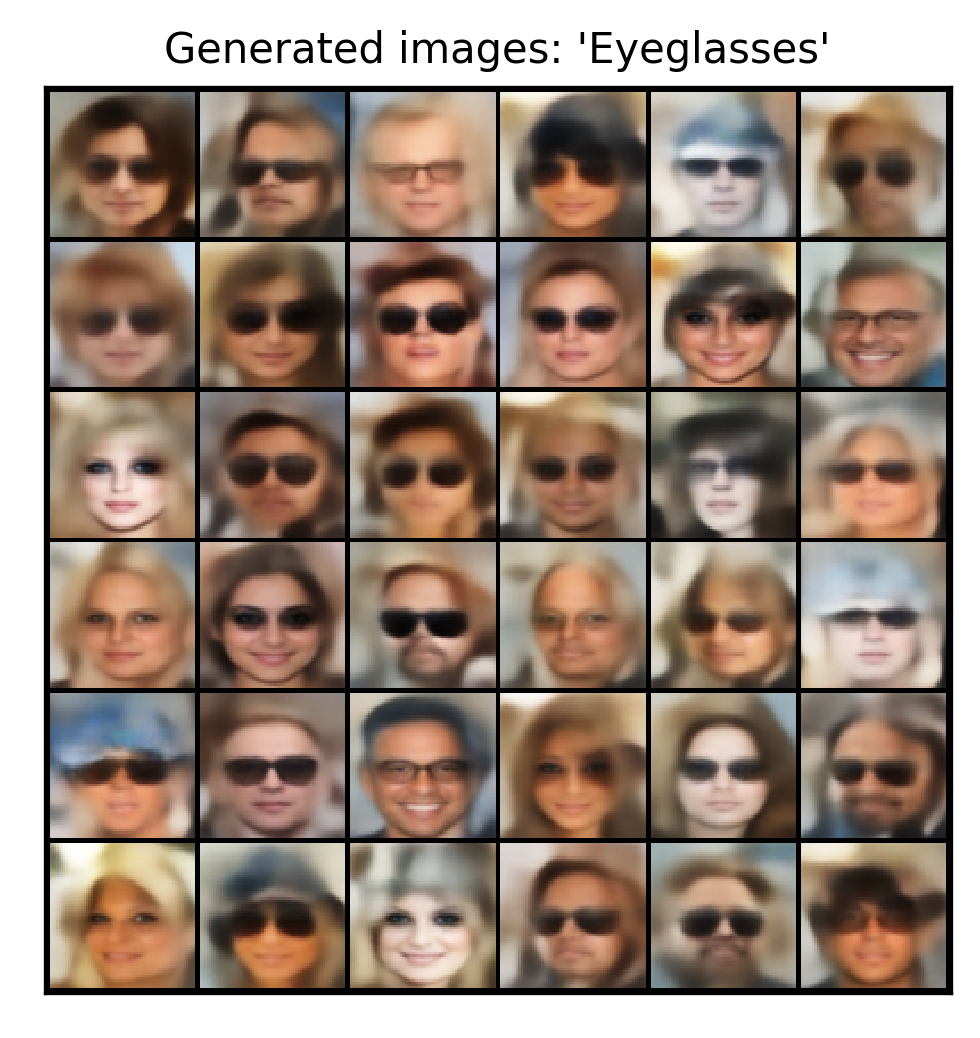

In [50]:
recon_images, _ = generate_images_with_attrs(model, ["Eyeglasses"], N=36, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses'", "model_good_Eyeglasses.png", make_grid((recon_images).cpu(), 6))

In [53]:
gen_accuracy(model, clf, ["Eyeglasses"], N=1000, device=torch.device("cuda:0"))

100%|██████████| 10/10 [00:00<00:00, 67.88it/s]

Accuraci for attr 'Eyeglasses': 0.36399999260902405


#### Generate: 'Eyeglasses', 'Smiling'

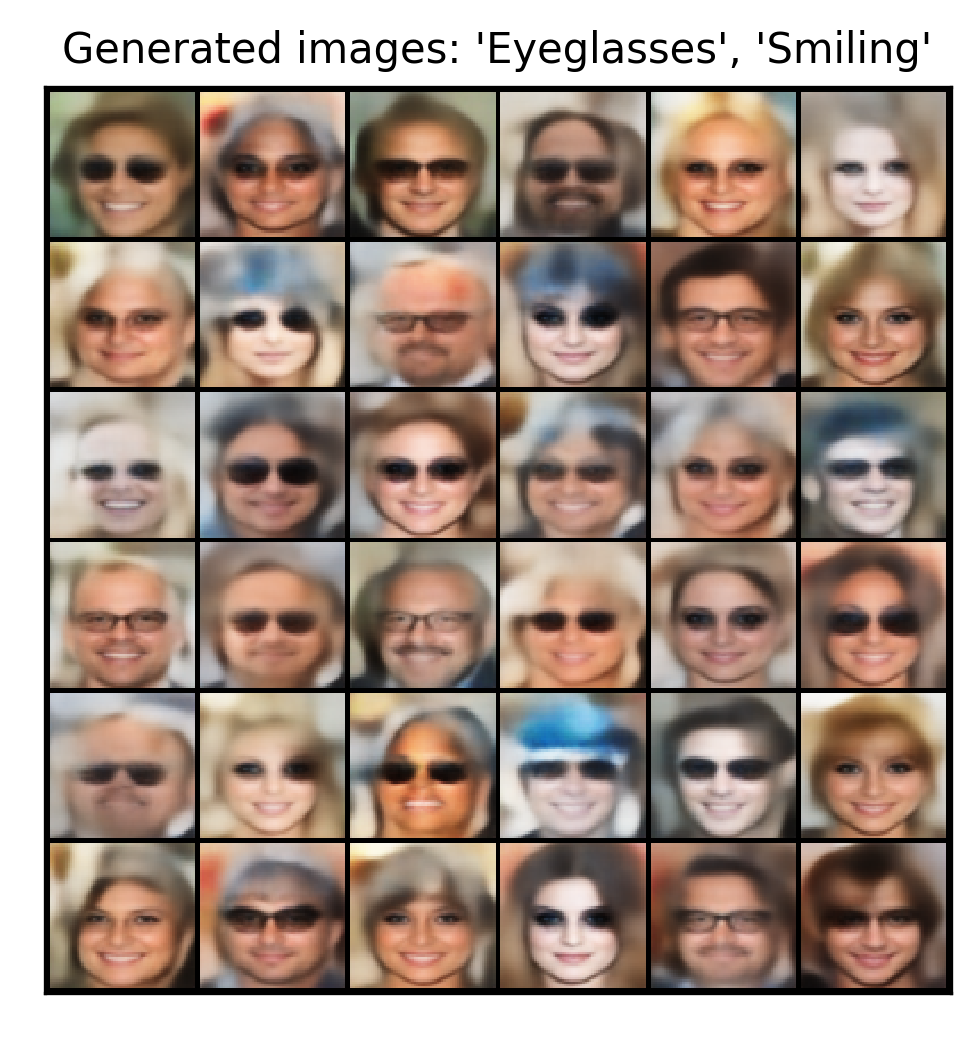

In [55]:
recon_images, _ = generate_images_with_attrs(model, ['Eyeglasses', 'Smiling'], N=36, device=torch.device("cuda:0"))
show("Generated images: 'Eyeglasses', 'Smiling'", "model_good_Eyeglasses_Smile.png", make_grid((recon_images).cpu(), 6))

In [56]:
gen_accuracy(model, clf, ['Eyeglasses', 'Smiling'], N=1000, device=torch.device("cuda:0"))

100%|██████████| 10/10 [00:00<00:00, 72.48it/s]

Accuraci for attr 'Eyeglasses': 0.23899999260902405
Accuraci for attr 'Smiling': 0.8770000338554382


#### Generate: 'Male'

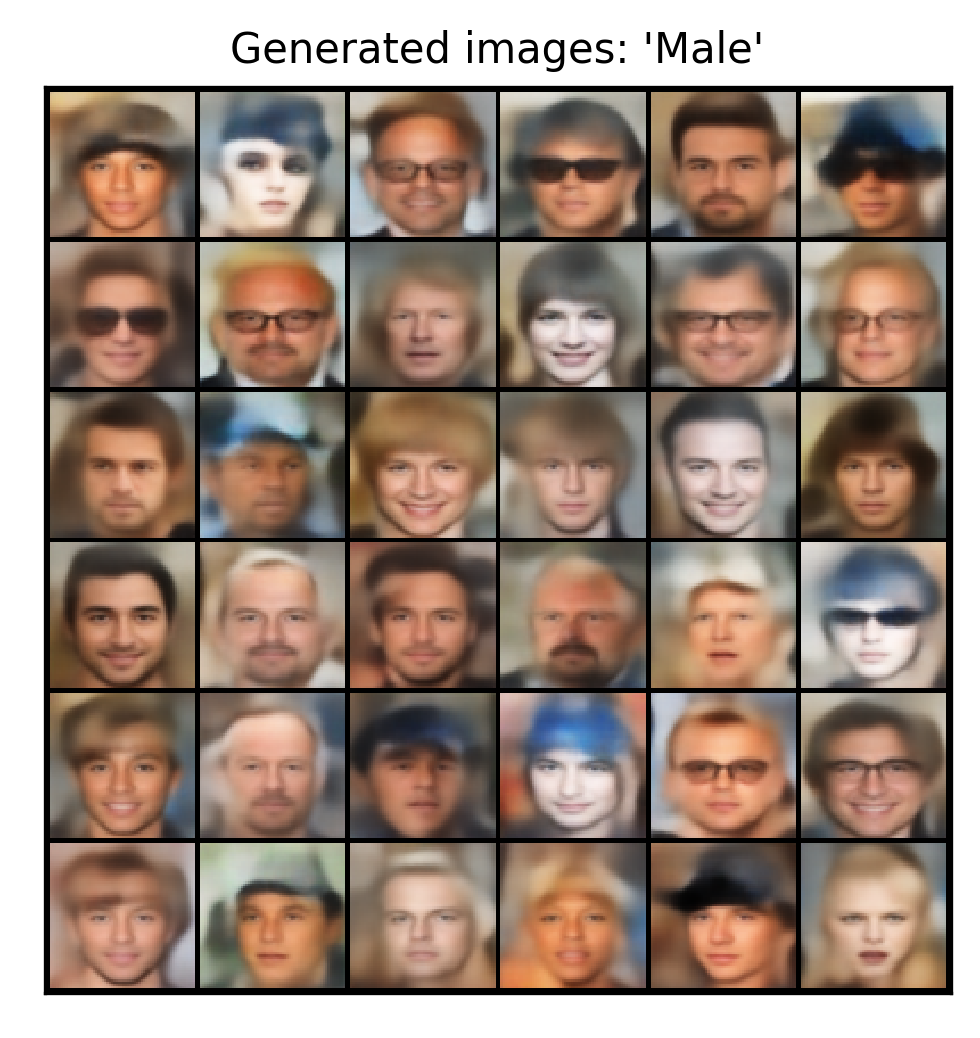

In [58]:
recon_images, _ = generate_images_with_attrs(model, ['Male'],
                                          no_attr_list=['Heavy_Makeup', "Wearing_Lipstick"],
                                          N=36, device=torch.device("cuda:0"))
show("Generated images: 'Male'", "model_good_Male.png", make_grid((recon_images).cpu(), 6))

In [60]:
gen_accuracy(model, clf, ['Male'],
             no_attr_list=['Heavy_Makeup', "Wearing_Lipstick"], N=1000, device=torch.device("cuda:0"))

100%|██████████| 10/10 [00:00<00:00, 70.46it/s]

Accuraci for attr 'Male': 0.7540000677108765


#### Generate: 'Heavy_Makeup'

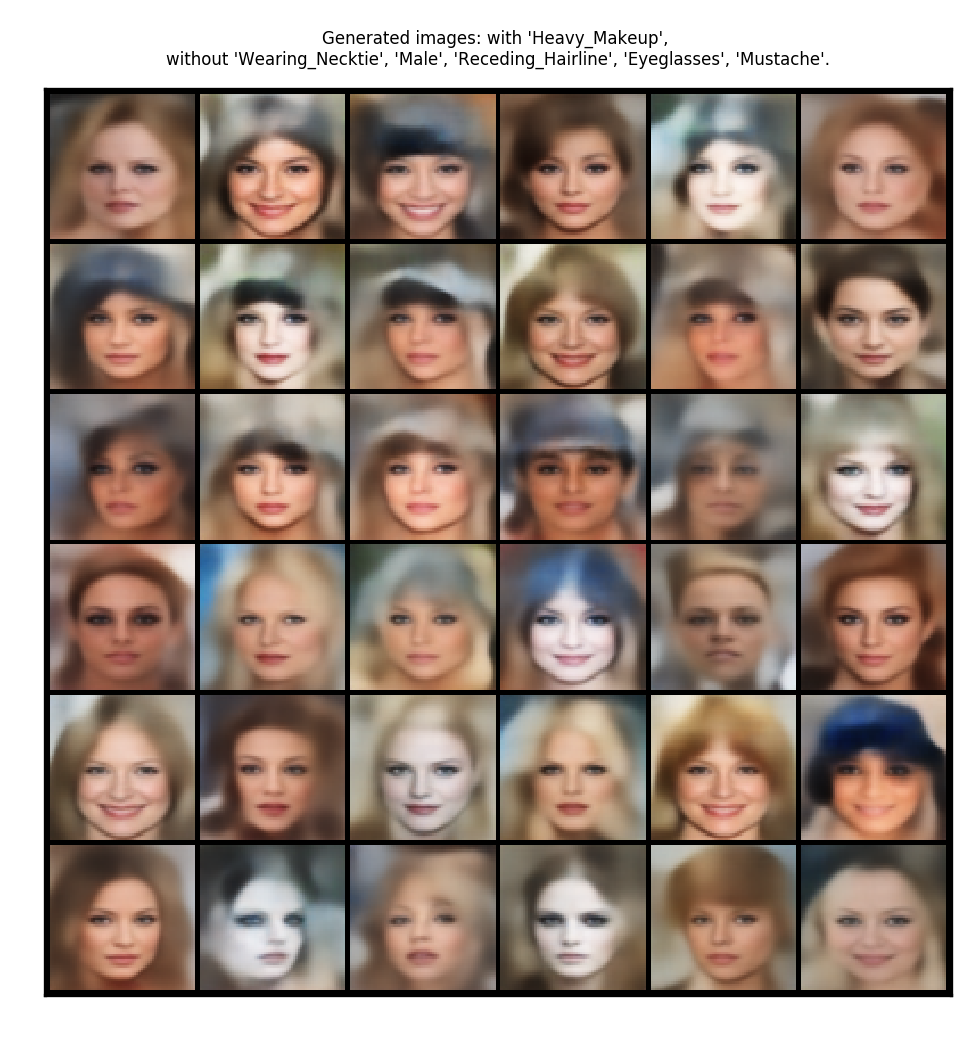

In [61]:
recon_images, _ = generate_images_with_attrs(model, with_attr_list=['Heavy_Makeup'], 
                                          no_attr_list=["Wearing_Necktie", "Male", "Receding_Hairline",
                                                        "Mustache", "Eyeglasses"], 
                                          N=36, device=torch.device("cuda:0"))
show("Generated images: with 'Heavy_Makeup', " + 
     "\nwithout 'Wearing_Necktie', 'Male', 'Receding_Hairline', 'Eyeglasses', 'Mustache'.", 
      "model_good_Makeup.png",
     make_grid((recon_images).cpu(), 6), fontsize=4)

In [62]:
gen_accuracy(model, clf, with_attr_list=['Heavy_Makeup'], 
            no_attr_list=["Wearing_Necktie", "Male", "Receding_Hairline", "Mustache", "Eyeglasses"], 
             N=1000, device=torch.device("cuda:0"))

100%|██████████| 10/10 [00:00<00:00, 69.20it/s]

Accuraci for attr 'Heavy_Makeup': 0.625


## Style transfer: 'Smiling'

In [8]:
attr_name = 'Smiling'
ind = attr_of_interest_to_idx[attr_name]
Z_with = []
Z_no = []

In [9]:
# Calculating the mean Z for samples with 'Smiling' and without 'Smiling'

for i, (image, attrs) in tqdm(enumerate(dataloaders["train"])):
    image = image.float().to(device)
    attrs = attrs.float().to(device)
    recon_image_1, recon_attrs_1, mu_1, logvar_1 = model(image, attrs, device=device)
    
    z_hat = model.reparameterize(mu_1, logvar_1)
    
    for j in range(z_hat.shape[0]):
        
        if attrs[j, ind] == 1:
            Z_with.append(z_hat[j])
            
        if attrs[j, ind] == 0:
            Z_no.append(z_hat[j])
            
    if i == 50:
        break


0it [00:00, ?it/s]/home/artem/.conda/envs/pytorch1_3/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
49it [00:23,  1.89it/s]

In [10]:
Z_with_mean = torch.mean(torch.stack(Z_with), dim=0)
Z_no_mean = torch.mean(torch.stack(Z_no), dim=0)

Z_move = Z_with_mean - Z_no_mean

In [14]:
# Attr
attr_name = 'Smiling'
ind = attr_of_interest_to_idx[attr_name]
attrs = np.zeros(N_ATTRS)
inds = np.arange(N_ATTRS)
np.random.shuffle(inds)
attrs[list(inds)[:6]] = 1
attrs[ind] = 0
attrs = torch.tensor(attrs).float()

recon_image, recon_attrs, mu, logvar = model(attrs=attrs[None].cuda(), device=device)
z_hat = model.reparameterize(mu, logvar)

attrs_recons = []
for alpha in [0., 0.55, 1., 1.2, 1.5, 2.]:
    z_hat_i = z_hat + alpha * Z_move

    mu_x, logvar_x = model.VAE.p_x(z_hat_i)

    attrs_recons.append(torch.sigmoid(mu_x))
    
#     plt.imshow(torch.sigmoid(mu_x[0]).detach().cpu().numpy().transpose(1, 2, 0))

In [15]:
torch.stack(attrs_recons, dim=1)[0].shape
Z = torch.stack(attrs_recons, dim=1)[0]
Z = Z.detach()

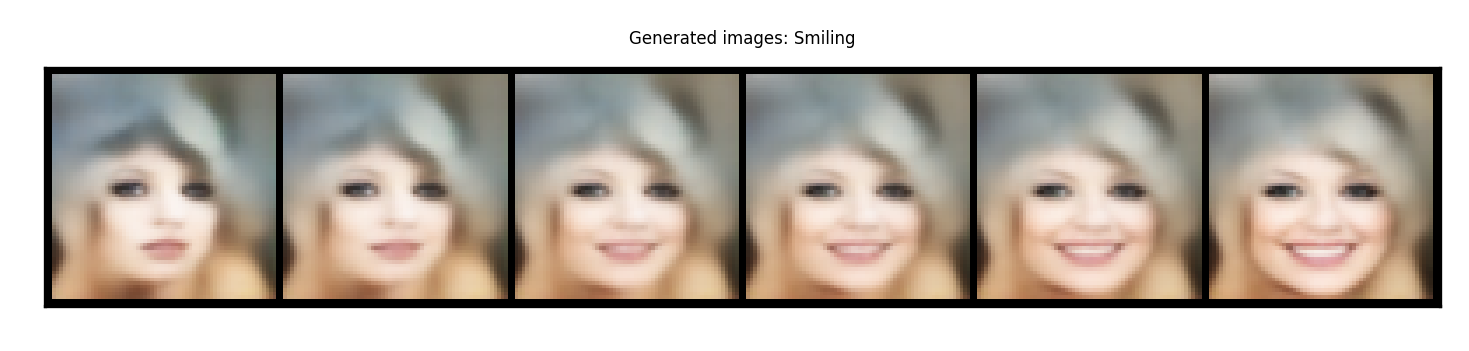

In [18]:
show("Generated images: Smiling", 
      "model_good_Makeup.png",
     make_grid(Z.cpu(), 6), fontsize=4)